In [572]:
import umap
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [762]:
# test model
test_model = "/volatile/jc225751/Runs/45_forcing_with_betaVAE_latents/Output/L1_representations/lambda-0.3/15-28-07_0"

# UMAP

In [763]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [764]:
def visualize_umaps(model_path, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75], show_wrong_class=False, verbose=False):
    # load the data
    data_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)
    
    if verbose:
        print("Data df:")
        print(data_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(visual_embs.shape)
        print(visual_embs[:5])
        
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    # plot for predicted labels
    n_i = len(quantiles)
    n_j = len(thresholds)
    plt.figure(figsize=(n_i*6.4, n_j*4.8))
    for i,quantile in enumerate(quantiles):
        svm_model, model_auc = get_model_by_quality(prediction_df, q=quantile)
        model_auc = "{:.2f}".format(model_auc)
        if verbose:
            print(f"Chosen svm model for quantile {quantile} (ie auc={model_auc}):")
        
        for j,threshold in enumerate(thresholds):
            plt.subplot(n_i, n_j, i*n_j + j + 1)
            
            mid_svm_pred = (prediction_df[svm_model] >= threshold).astype(int)
            if verbose:
                print(mid_svm_pred[:5])
                print("shape:", mid_svm_pred.shape)

            colors = [cmap[i] for i in mid_svm_pred]
            if show_wrong_class:
                colors = []
                # for i in range(prediction_df.shape[0]):
                #     if prediction_df[la]

            plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
            if i == n_i-1:
                plt.xlabel(f"Decision threshold = {threshold}")
            if j == 0:
                plt.ylabel(f"Model quality={quantile} (auc={model_auc})")
            # compute accuracy
            accuracy = ((prediction_df[svm_model] >= threshold) == prediction_df.label).astype(float).mean()
            plt.title("Svm labels ; accuracy = {:.2f}".format(accuracy))
    plt.show()

    return pd.DataFrame(visual_embs, index=data_df.index.values)

In [765]:
def full_visualization(model_path):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/cingulate_ACCpatterns_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path)

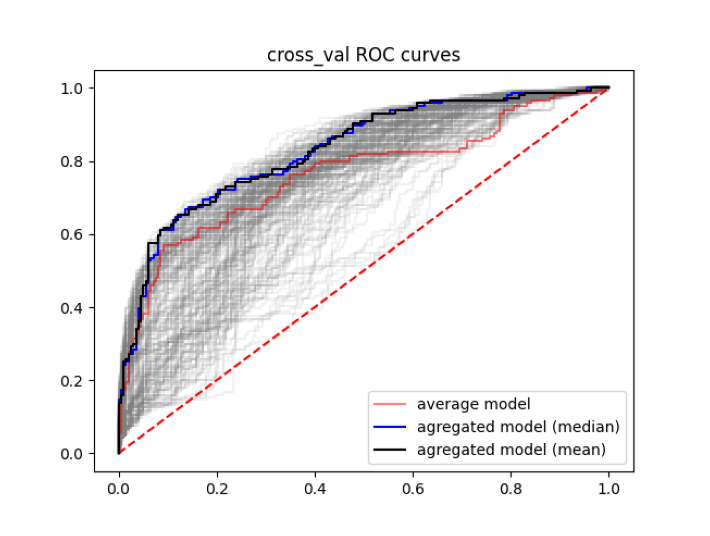

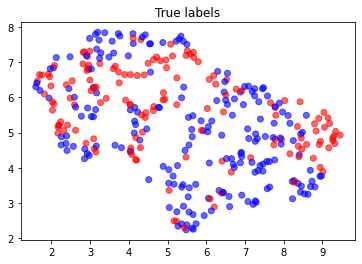

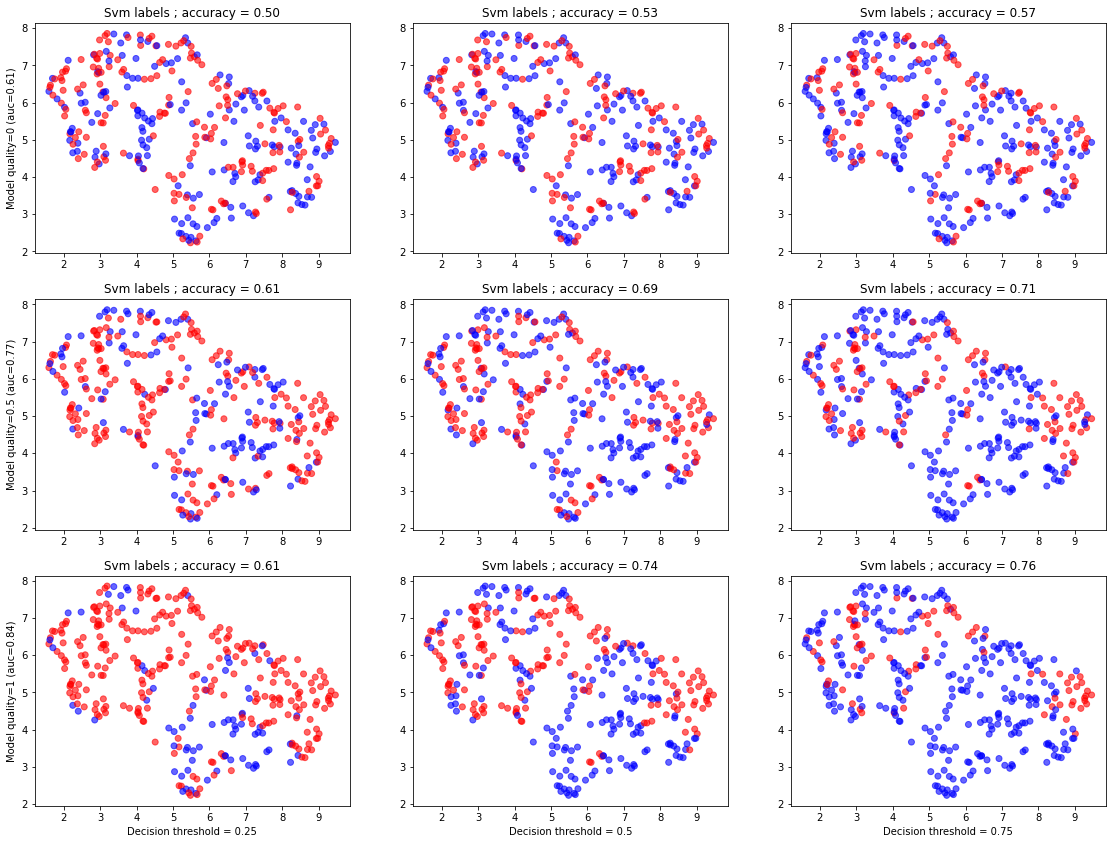

In [766]:
# test model
visual_embs = full_visualization(test_model)

# Visualize each variable of the latent

In [767]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

x, full_df and colors shapes:  (341, 30) (341, 31) (341, 30)
(30,) (30,) (30,)


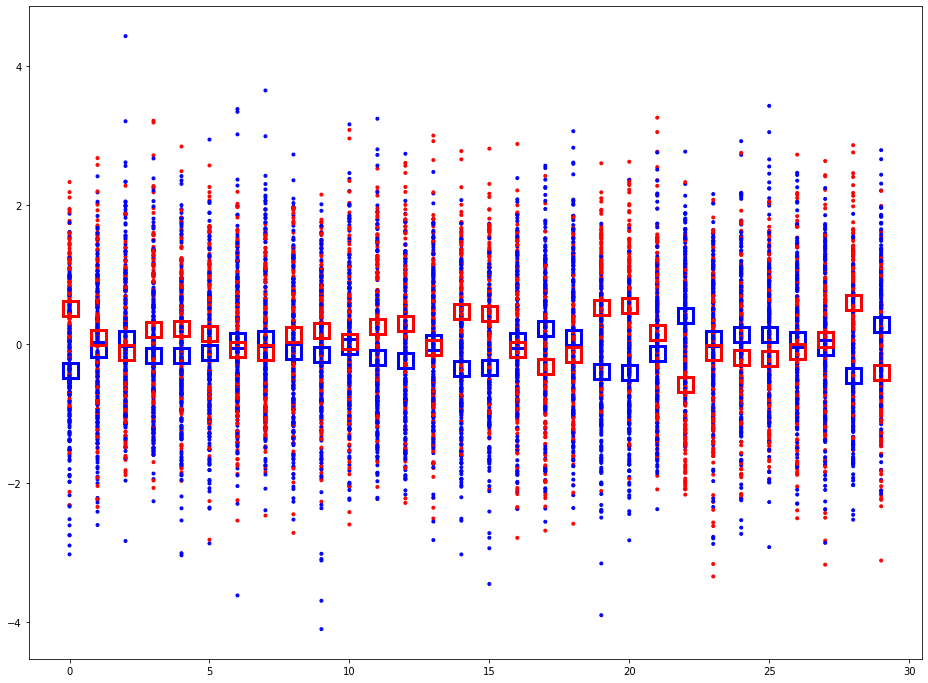

In [772]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=True, verbose=False)

In [773]:
def cross_correlation(model_path):
    # load the data
    data_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


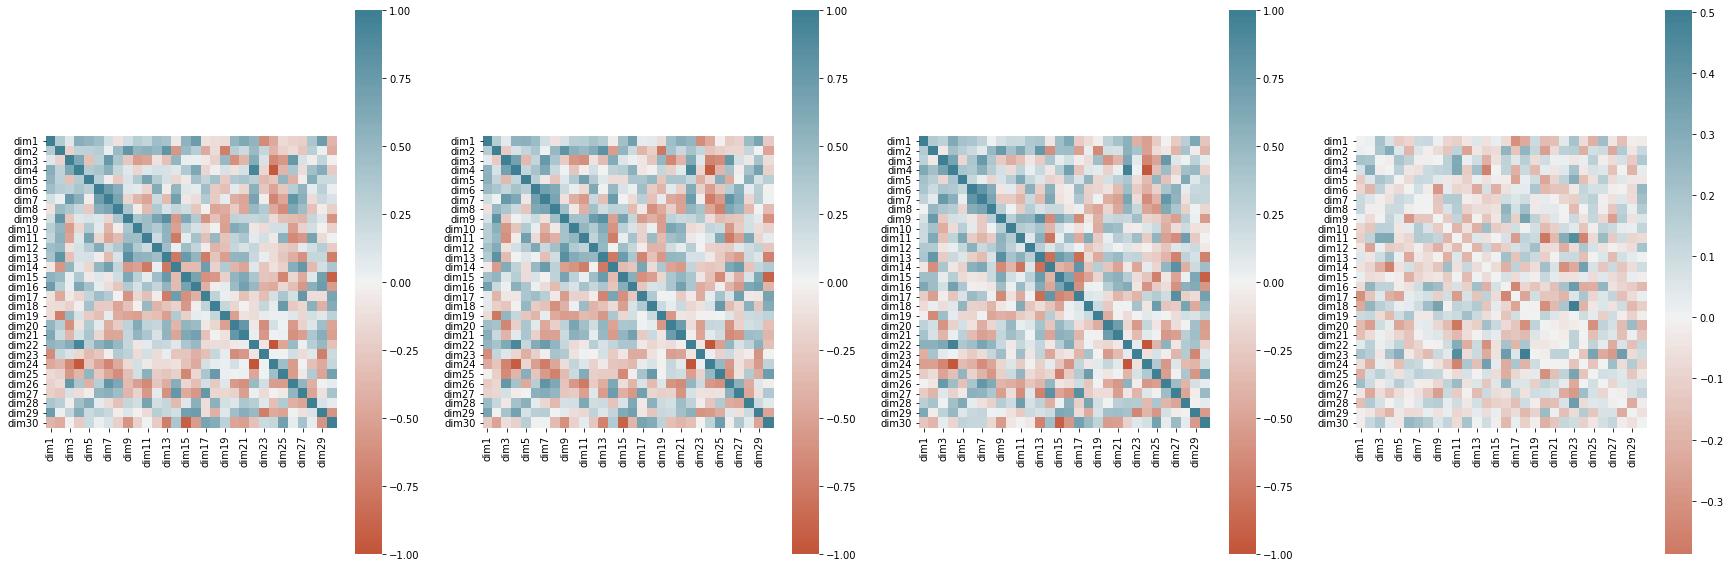

In [774]:
cross_correlation(test_model)

# Misc

In [13]:
visual_embs

0         1
1-03HUBJO_t0                           2.595306  7.511717
1-08ANDTI_t0                           7.059879  9.800155
1-11LEBJO_t0                          -1.234549  6.561519
1-15LEHMI_t0                           1.584999  7.673613
1-17COLMA_t0                           4.243817  6.846089
...                                         ...       ...
sub-inhibition25_ses-pretraining_T1w  -5.302184  1.991356
sub-inhibition26_ses-pretraining_T1w  -4.234701  3.359888
sub-inhibition28_ses-pretraining_T1w  12.931166  7.553495
sub-inhibition29_ses-pretraining_T1w   9.860889  8.007633
sub-inhibition31_ses-pretraining_T1w   1.467356  6.079006

[341 rows x 2 columns]

In [14]:
visual_embs[visual_embs[0] >= 12].sample(n=5).index

Index(['a0012_t1_s03', 'nih_chp_04767_t1', 'nih_chp_02991_t1', '2-09MORJU_t0',
       'nih_chp_04452_t1'],
      dtype='object')

## Choose relevent SimCLR models

In [9]:
bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models.csv", index_col=0)
bdd.sort_values(by='auc', ascending=False, inplace=True)
bdd

model_path       auc   auc_std  \
116  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.694205  0.008692   
75   /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.693590  0.051831   
25   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.692153  0.049598   
91   /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.678702  0.006920   
12   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.678640  0.044072   
..                                                 ...       ...       ...   
59   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.480352  0.022429   
100  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.478818  0.022703   
19   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.473885  0.042166   
38   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.466274  0.034258   
129  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.463362  0.009882   

     accuracy  accuracy_std backbone_name  batch_size  drop_rate  \
116  0.669267      0.009264      pointnet          16       0.15   
75   0.619449      0.052646      densenet          16       0.05   
25   0.629595      0.054254      densenet          16       0.15   
91   0.668692      0.007873      pointnet          16       0.05   
12   0.634545      0.037935       convnet          16       0.15   
..        ...           ...           ...         ...        ...   
59   0.549314      0.014923           NaN          16       0.15   
100  0.576880      0.003572      pointnet          16       0.05   
19   0.510393      0.050783       convnet          16       0.15   
38   0.547683      0.020623      densenet          16       0.15   
129  0.559331      0.002454      pointnet          16       0.05   

     early_stopping_patience  foldlabel  ... max_angle  max_epochs  \
116                      100       True  ...         6         250   
75                       100       True  ...         6         250   
25                       100       True  ...         6         250   
91                       100       True  ...         6         250   
12                       100      False  ...        10         250   
..                       ...        ...  ...       ...         ...   
59                       100      False  ...        10         250   
100                      100       True  ...         6         250   
19                       100      False  ...        10         250   
38                       100      False  ...        10         250   
129                      100      False  ...        10         250   

     num_outputs  num_representation_features  temperature  \
116           30                           30          0.5   
75            30                           30          0.1   
25            30                           30          0.1   
91            30                           30          0.1   
12            30                           30          0.1   
..           ...                          ...          ...   
59             4                            4          0.1   
100            4                            4          0.5   
19             4                            4          0.1   
38             4                            4          0.1   
129            4                            4          0.1   

     temperature_initial  train_loss  val_loss          dataset_name  \
116                  0.5    4.367986  4.052493  cingulate_HCP_half_1   
75                   0.1    0.762840  1.369004  cingulate_HCP_half_1   
25                   0.1    1.032371  2.509686  cingulate_HCP_half_1   
91                   0.1    1.336895  2.419318  cingulate_HCP_half_1   
12                   0.1    0.263586  0.195343  cingulate_HCP_half_1   
..                   ...         ...       ...                   ...   
59                   0.1    6.815775  6.824551  cingulate_HCP_half_1   
100                  0.5    5.256860  5.389712  cingulate_HCP_half_1   
19                   0.1    8.022524  6.433455  cingulat

In [10]:
best_model = bdd.iloc[0,:]
best_model = best_model.model_path
print(best_model)

worst_model = bdd.iloc[-1,:]
worst_model = worst_model.model_path
print(worst_model)

/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/fold_30_T=0.5
/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/no_4_drop_rate=0.05


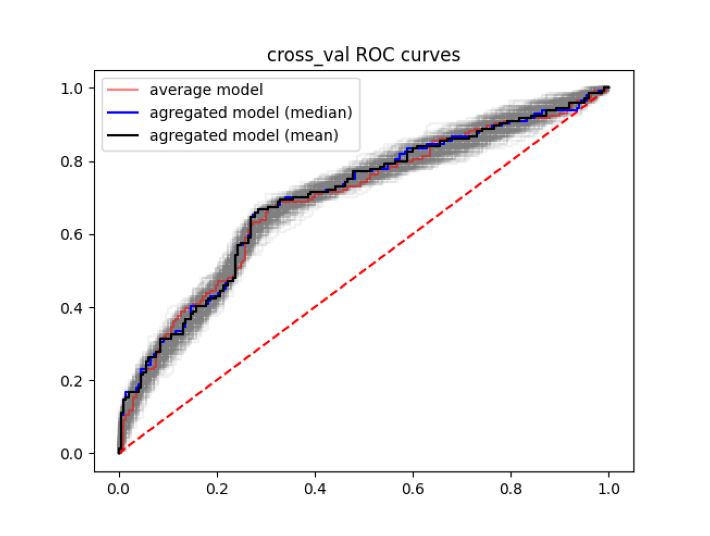

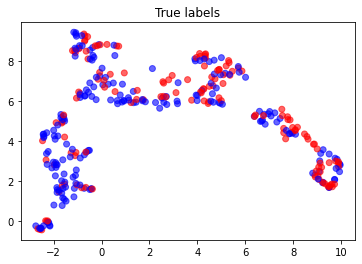

COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1.085944
1-08ANDTI_t0    0.370679
1-11LEBJO_t0    0.379897
1-15LEHMI_t0    0.838717
1-17COLMA_t0   -0.093154
Name: predicted_0, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1.051383
1-08ANDTI_t0    0.834513
1-11LEBJO_t0    0.850434
1-15LEHMI_t0    1.045822
1-17COLMA_t0    0.254660
Name: predicted_1, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int6

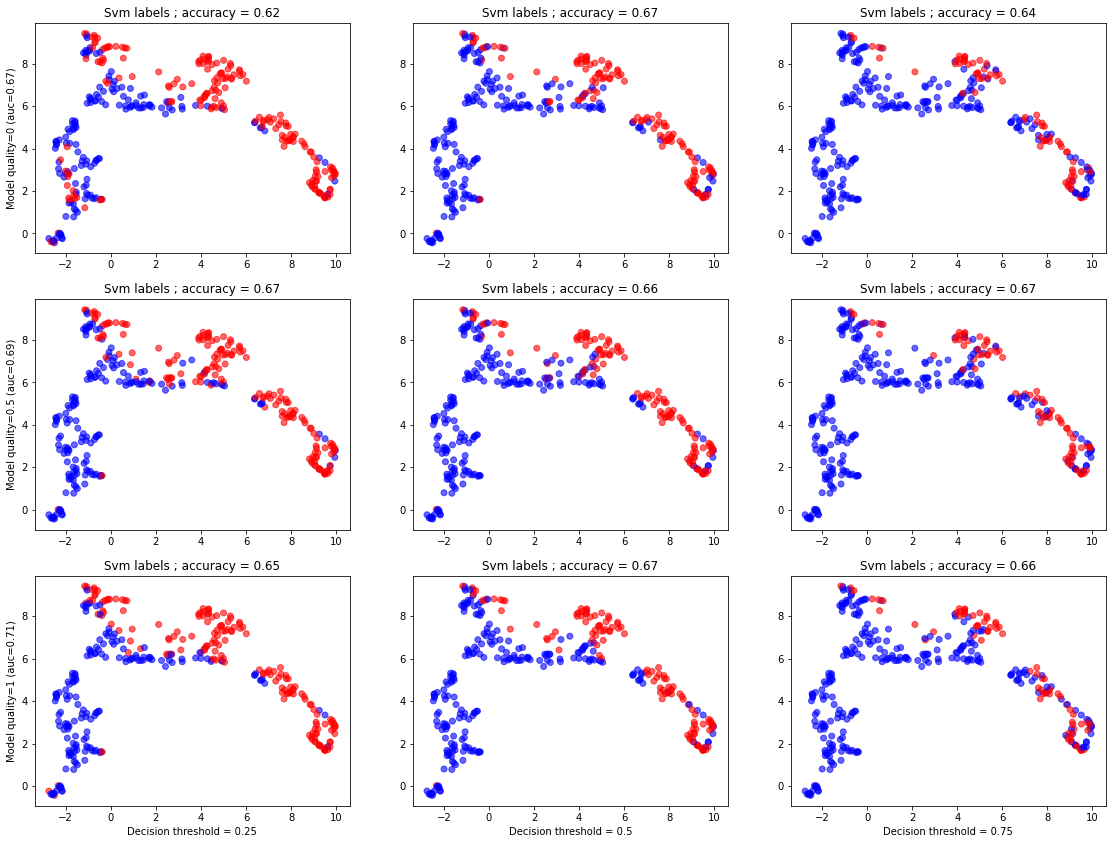

0         1
1-03HUBJO_t0                          9.186221  2.682998
1-08ANDTI_t0                          4.656048  6.753619
1-11LEBJO_t0                          4.497620  6.724754
1-15LEHMI_t0                          0.556443  8.261779
1-17COLMA_t0                         -1.186261  2.189207
...                                        ...       ...
sub-inhibition25_ses-pretraining_T1w -0.580398  9.205417
sub-inhibition26_ses-pretraining_T1w -0.827660  9.257190
sub-inhibition28_ses-pretraining_T1w -1.603822  1.625668
sub-inhibition29_ses-pretraining_T1w -0.545390  6.430453
sub-inhibition31_ses-pretraining_T1w -1.500566  1.696223

[341 rows x 2 columns]

In [11]:
full_visualization(best_model)

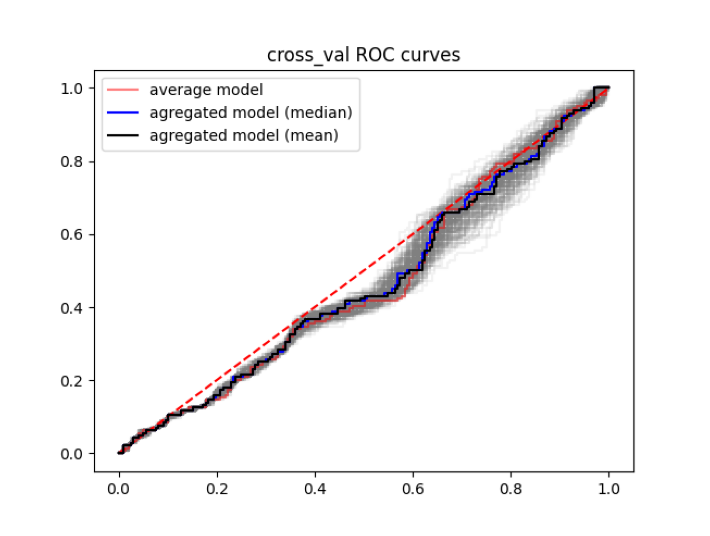

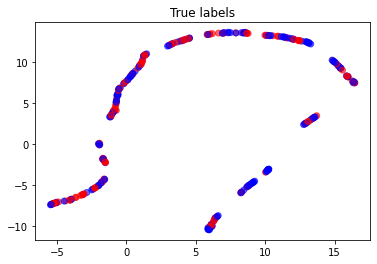

COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    0.010074
1-08ANDTI_t0   -0.001354
1-11LEBJO_t0    0.000243
1-15LEHMI_t0    0.056851
1-17COLMA_t0    0.001901
Name: predicted_0, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    0.022286
1-08ANDTI_t0    0.003772
1-11LEBJO_t0    0.006420
1-15LEHMI_t0    0.048039
1-17COLMA_t0    0.000295
Name: predicted_1, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int6

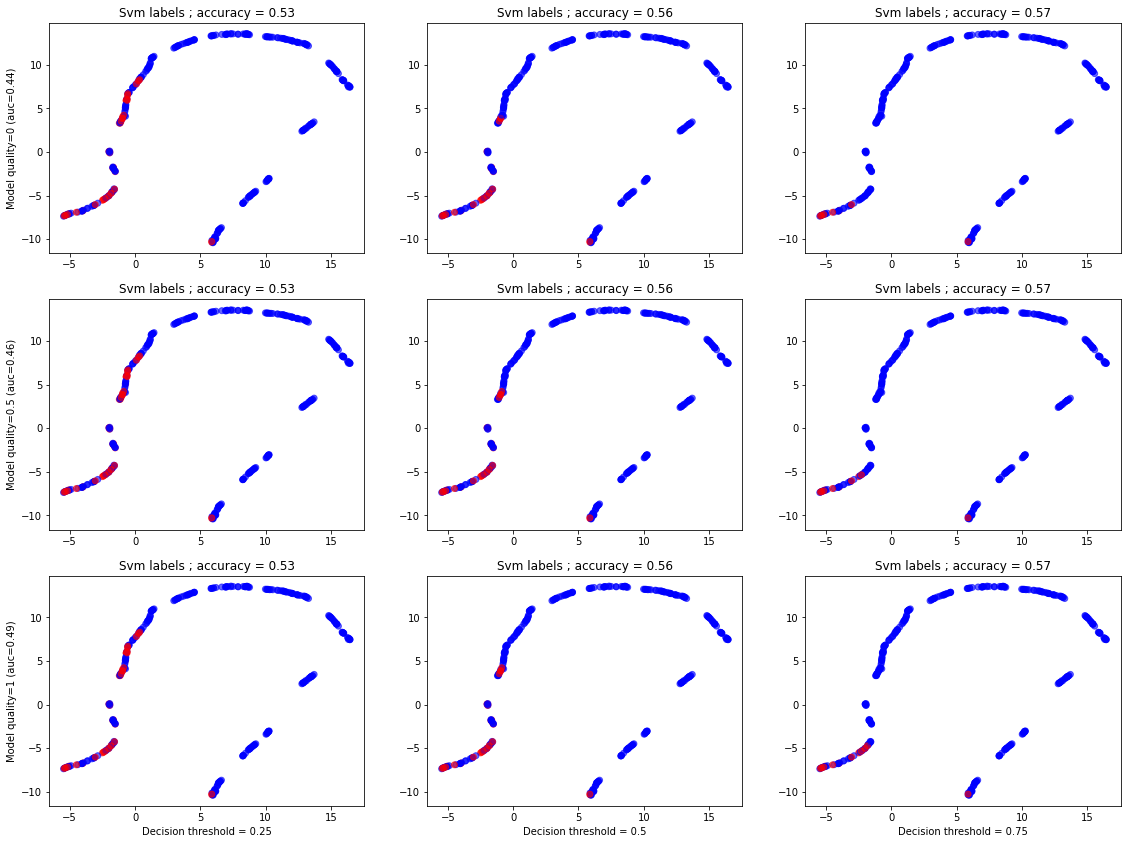

0          1
1-03HUBJO_t0                           6.947111  13.514153
1-08ANDTI_t0                          15.439292   9.237772
1-11LEBJO_t0                          14.876024  10.165723
1-15LEHMI_t0                           8.260912  -5.889405
1-17COLMA_t0                          10.165199  -3.166095
...                                         ...        ...
sub-inhibition25_ses-pretraining_T1w   6.123514  -9.791336
sub-inhibition26_ses-pretraining_T1w  10.242856  -3.059696
sub-inhibition28_ses-pretraining_T1w  -5.428968  -7.332220
sub-inhibition29_ses-pretraining_T1w  10.246349  13.221717
sub-inhibition31_ses-pretraining_T1w   5.878088 -10.286034

[341 rows x 2 columns]

In [12]:
full_visualization(worst_model)

### Select other interesting models

High variance models

In [13]:
filtered_bdd = bdd[bdd.auc_std >= 0.05]
filtered_bdd

model_path       auc   auc_std  \
75  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.693590  0.051831   
76  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.670914  0.051652   
24  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.668507  0.053301   
78  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.668161  0.050466   
22  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.627084  0.052677   
47  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.626335  0.050238   
72  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.593398  0.056054   
5   /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.581583  0.057815   
67  /neurospin/dico/agaudin/Runs/04_pointnet/Outpu...  0.576889  0.056377   
43  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.574575  0.063551   
27  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.547569  0.057362   
29  /neurospin/dico/agaudin/Runs/03_monkeys/Output...  0.519898  0.052222   

    accuracy  accuracy_std backbone_name  batch_size  drop_rate  \
75  0.619449      0.052646      densenet          16       0.05   
76  0.596364      0.056285      densenet          16       0.05   
24  0.601525      0.057313      densenet          16       0.15   
78  0.598956      0.053273      densenet          16       0.05   
22  0.577161      0.053945      densenet          16       0.15   
47  0.598792      0.041902       convnet          16       0.15   
72  0.585232      0.040975       convnet          16       0.05   
5   0.562100      0.052206       convnet          16       0.15   
67  0.567038      0.039782       convnet          16       0.15   
43  0.555718      0.051553       convnet          16       0.15   
27  0.539683      0.044184      densenet          16       0.15   
29  0.517889      0.044333      densenet          16       0.15   

    early_stopping_patience  foldlabel  ... max_angle  max_epochs  \
75                      100       True  ...         6         250   
76                      100       True  ...         6         250   
24                      100       True  ...         6         250   
78                      100       True  ...         6         250   
22                      100       True  ...         6         250   
47                      100      False  ...        10         250   
72                      100       True  ...         6         250   
5                       100       True  ...         6         250   
67                      100      False  ...        10          20   
43                      100       True  ...         6         250   
27                      100       True  ...         6         250   
29                      100       True  ...         6         250   

    num_outputs  num_representation_features  temperature  \
75           30                           30         0.10   
76           30                           30         0.10   
24           30                           30         0.10   
78           30                           30         0.10   
22           30                           30         0.10   
47           30                           30         0.01   
72           30                           30         0.50   
5             4                            4         0.10   
67           30                           12         0.50   
43            4                            4         0.10   
27            4                            4         0.10   
29            4                            4         0.10   

    temperature_initial  train_loss  val_loss          dataset_name  \
75                  0.1    0.762840  1.369004  cingulate_HCP_half_1   
76                  0.1    1.159750  2.443445  cingulate_HCP_half_1   
24                  0.1    0.728199  1.858723  cingulate_HCP_half_1   
78                  0.1    1.041767  1.704926  cingulate_HCP_half_1   
22                  0.1    1.329955  3.381569  cingulate_HCP_half_1   
47                  0.1    0.172071  0.144276  cing

In [14]:
high_variance_good = filtered_bdd.iloc[0,:].model_path
high_variance_bad = filtered_bdd.iloc[-1,:].model_path

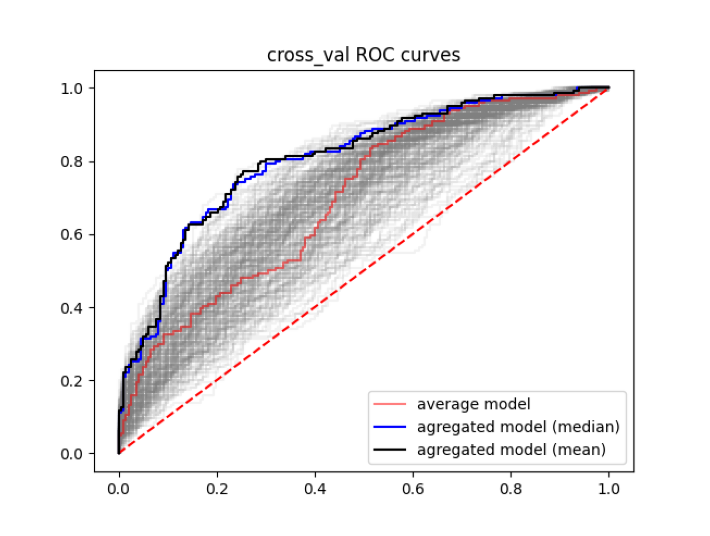

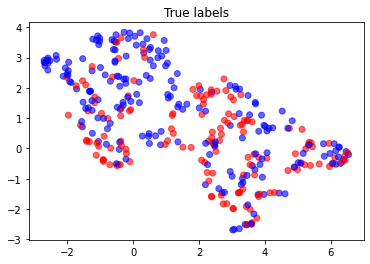

COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1.007062
1-08ANDTI_t0    0.452632
1-11LEBJO_t0    0.795762
1-15LEHMI_t0    0.543701
1-17COLMA_t0    0.054086
Name: predicted_0, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    0.653706
1-08ANDTI_t0   -0.063741
1-11LEBJO_t0    0.290454
1-15LEHMI_t0    0.197425
1-17COLMA_t0   -0.163997
Name: predicted_1, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int6

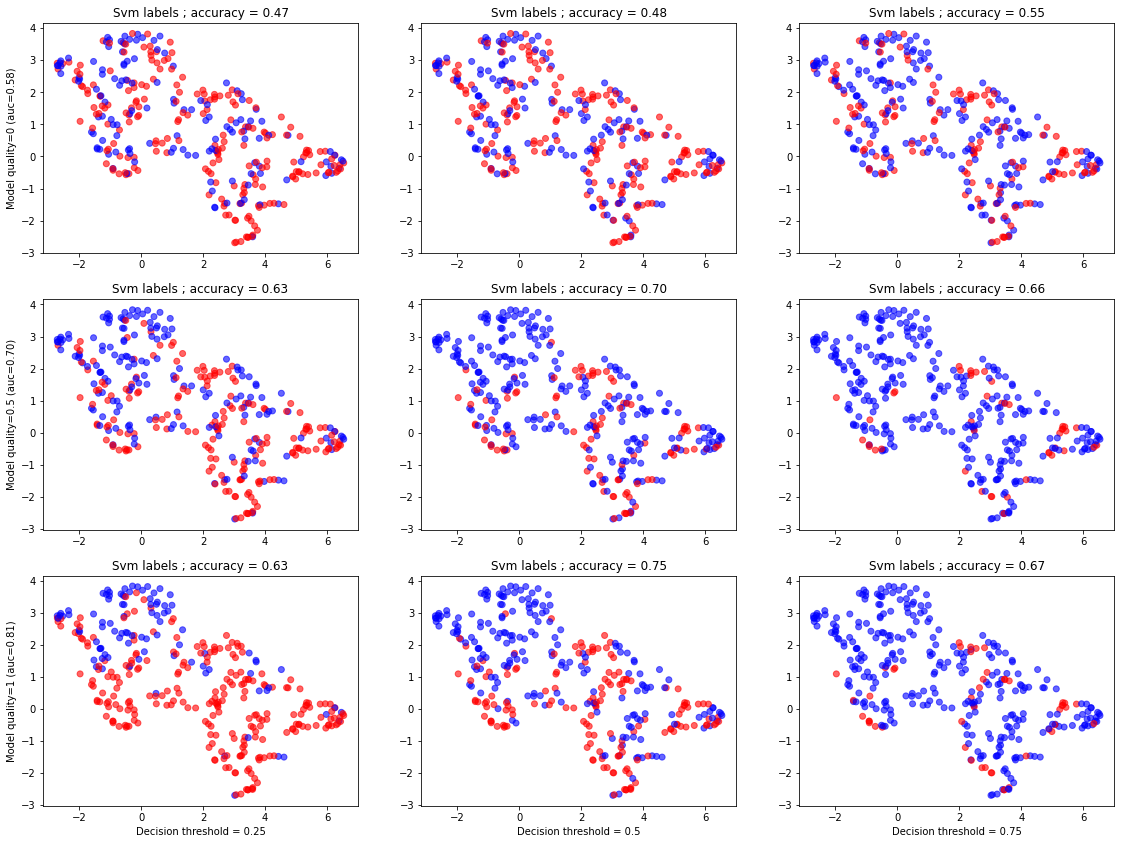

0         1
1-03HUBJO_t0                         -0.904413 -0.430103
1-08ANDTI_t0                         -0.151082  1.734918
1-11LEBJO_t0                         -0.076953  1.277926
1-15LEHMI_t0                         -0.425086 -0.034034
1-17COLMA_t0                          0.481138  0.487836
...                                        ...       ...
sub-inhibition25_ses-pretraining_T1w  5.400419  0.185369
sub-inhibition26_ses-pretraining_T1w  5.339092  0.118867
sub-inhibition28_ses-pretraining_T1w  3.064942 -2.673279
sub-inhibition29_ses-pretraining_T1w  3.715752 -0.177695
sub-inhibition31_ses-pretraining_T1w  3.703749  1.517895

[341 rows x 2 columns]

In [15]:
full_visualization(high_variance_good)

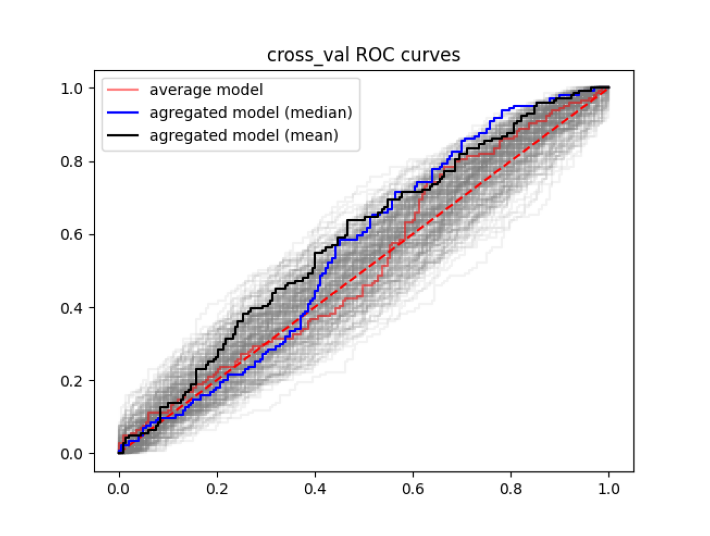

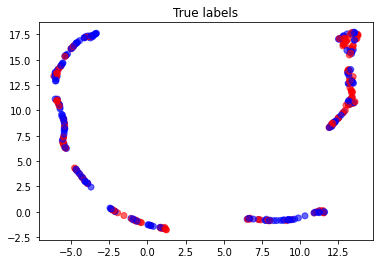

COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    0.000802
1-08ANDTI_t0    0.204496
1-11LEBJO_t0   -0.000556
1-15LEHMI_t0    0.168653
1-17COLMA_t0    0.129080
Name: predicted_0, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    0.880515
1-08ANDTI_t0   -0.217587
1-11LEBJO_t0    0.734192
1-15LEHMI_t0    0.003193
1-17COLMA_t0    0.174615
Name: predicted_1, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int6

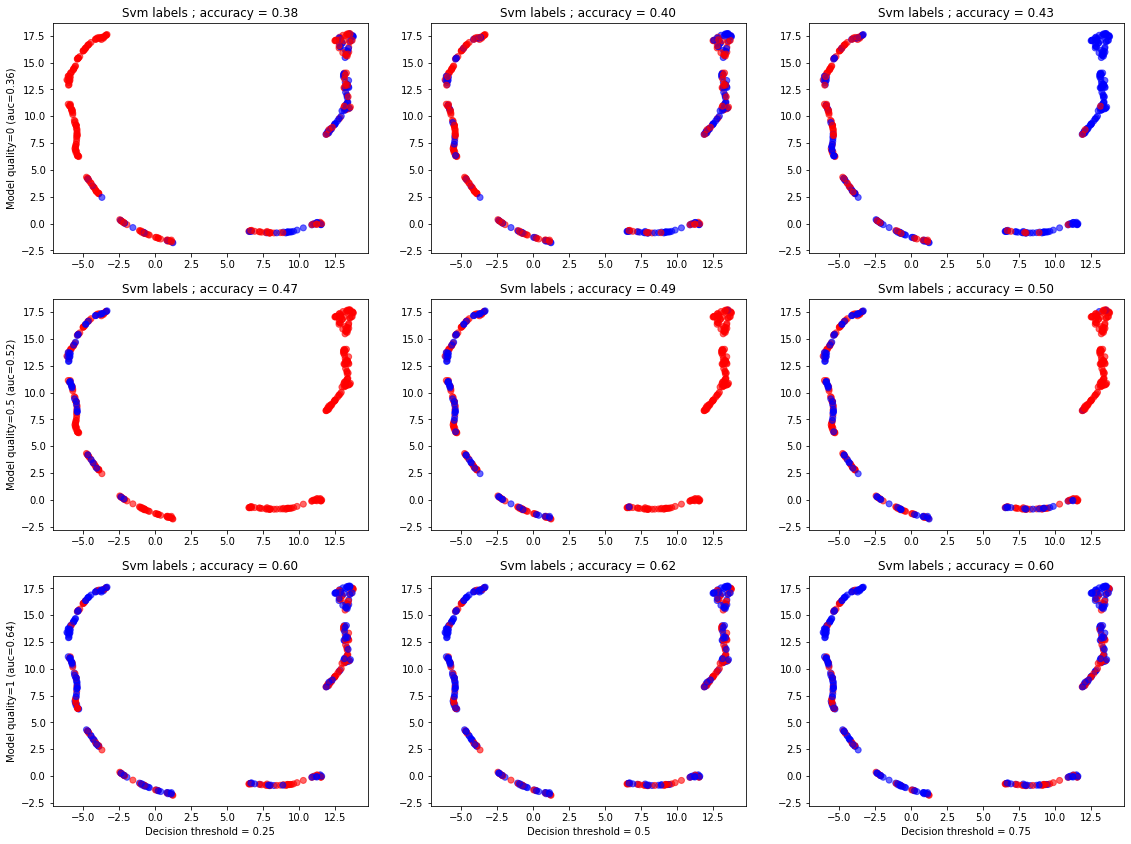

0          1
1-03HUBJO_t0                          12.798281   9.751040
1-08ANDTI_t0                          -5.477254   6.568720
1-11LEBJO_t0                          11.482759   0.124131
1-15LEHMI_t0                          -3.886184   2.770105
1-17COLMA_t0                          -1.072795  -0.648323
...                                         ...        ...
sub-inhibition25_ses-pretraining_T1w  13.342558  17.669209
sub-inhibition26_ses-pretraining_T1w  13.547603  17.632578
sub-inhibition28_ses-pretraining_T1w  -0.696114  -0.913531
sub-inhibition29_ses-pretraining_T1w  -4.291049   3.444685
sub-inhibition31_ses-pretraining_T1w  13.382536  12.903571

[341 rows x 2 columns]

In [16]:
full_visualization(high_variance_bad)

# Clustering

In [17]:
from sklearn.cluster import KMeans

In [18]:
def visualize_clusters(model_path, n_clusters=4, verbose=False):
    # load the data
    data_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)
    
    if verbose:
        print("Data df:")
        print(data_df[:5])

    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(data_df)

    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(visual_embs.shape)
        print(visual_embs[:5])
    
    # apply kmeans on the UMAP data
    kmeans = KMeans(n_clusters=n_clusters)
    labels2 = kmeans.fit_predict(visual_embs)
        
    ## plot the graphs
    plt.figure()
    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=labels, alpha=0.6)
    plt.title("Clusters before umap")
    plt.show()

    plt.figure()
    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=labels2, alpha=0.6)
    plt.title("Clusters after umap")
    plt.show()

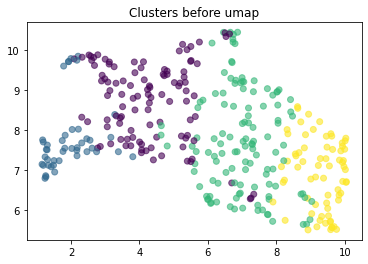

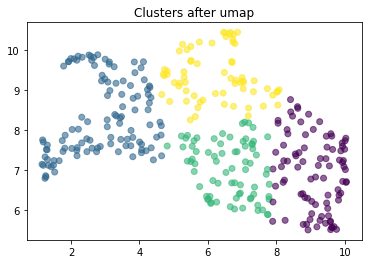

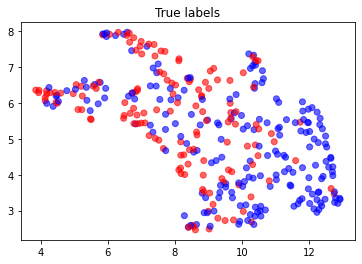

COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1.291116
1-08ANDTI_t0    0.715350
1-11LEBJO_t0    0.943959
1-15LEHMI_t0    0.841309
1-17COLMA_t0    0.609411
Name: predicted_0, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1.077150
1-08ANDTI_t0    0.763985
1-11LEBJO_t0    0.951556
1-15LEHMI_t0    0.748888
1-17COLMA_t0    0.359148
Name: predicted_1, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int6

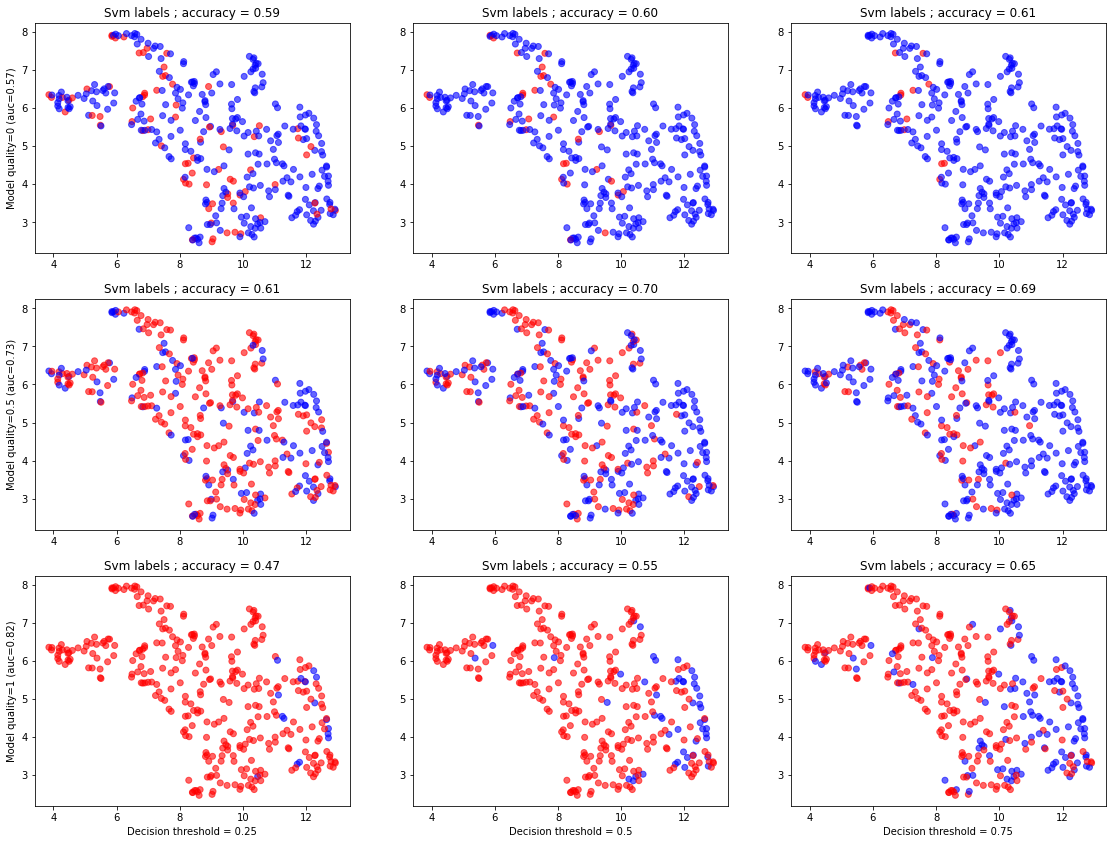

0         1
1-03HUBJO_t0                           6.486631  5.649004
1-08ANDTI_t0                           8.992952  2.982852
1-11LEBJO_t0                           9.018193  2.488648
1-15LEHMI_t0                          10.553809  3.120958
1-17COLMA_t0                          11.794770  6.028144
...                                         ...       ...
sub-inhibition25_ses-pretraining_T1w   4.137295  6.147345
sub-inhibition26_ses-pretraining_T1w   4.250442  6.425659
sub-inhibition28_ses-pretraining_T1w  10.313435  7.029488
sub-inhibition29_ses-pretraining_T1w  11.260559  4.082402
sub-inhibition31_ses-pretraining_T1w   9.510269  3.653815

[341 rows x 2 columns]

In [19]:
visualize_clusters(test_model)
visualize_umaps(test_model)

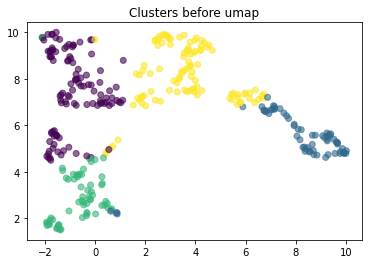

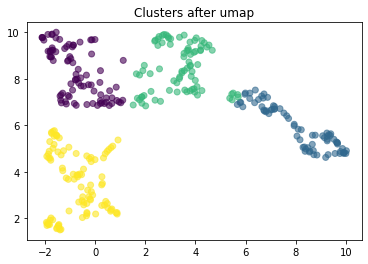

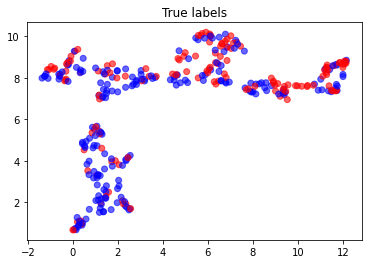

COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1.085944
1-08ANDTI_t0    0.370679
1-11LEBJO_t0    0.379897
1-15LEHMI_t0    0.838717
1-17COLMA_t0   -0.093154
Name: predicted_0, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int64
Subject
1-03HUBJO_t0    1.051383
1-08ANDTI_t0    0.834513
1-11LEBJO_t0    0.850434
1-15LEHMI_t0    1.045822
1-17COLMA_t0    0.254660
Name: predicted_1, dtype: float64
COMPUTE AUC
Subject
1-03HUBJO_t0    1
1-08ANDTI_t0    1
1-11LEBJO_t0    1
1-15LEHMI_t0    0
1-17COLMA_t0    0
Name: label, dtype: int6

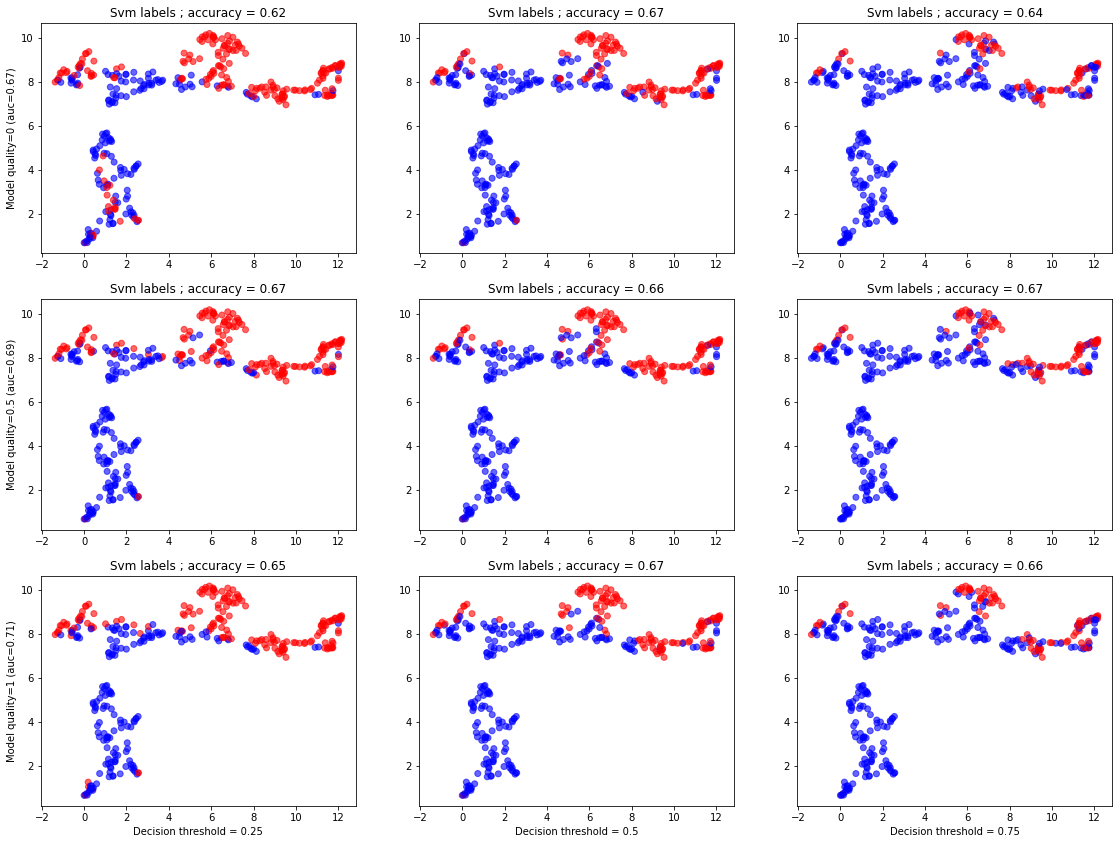

0         1
1-03HUBJO_t0                          11.282610  8.152096
1-08ANDTI_t0                           6.450228  8.674759
1-11LEBJO_t0                           6.340808  8.724228
1-15LEHMI_t0                           0.459979  8.934580
1-17COLMA_t0                           1.986583  2.665782
...                                         ...       ...
sub-inhibition25_ses-pretraining_T1w  -0.965394  8.541927
sub-inhibition26_ses-pretraining_T1w  -1.191988  8.182640
sub-inhibition28_ses-pretraining_T1w   1.464284  2.202323
sub-inhibition29_ses-pretraining_T1w   1.506201  7.383246
sub-inhibition31_ses-pretraining_T1w   1.435358  2.215742

[341 rows x 2 columns]

In [20]:
visualize_clusters(best_model)
visualize_umaps(best_model)

# Anatomist